# **Delivery Dron Analysis**

# **Описание проекта**
Необходимо проанализировать данные о продажах иностранной интернет компании “Delivery Dron”, занимающейся продажей дронов доставщиков и работающей в четырех регионах c мая 2019 года.
# **Задачи**

*   сделать отчет о вложенных средствах
*   построить планы на следующий год
*   **выяснить  в какой регион и какой рекламный канал инвестировать больше денег на привлечение клиентов в 2020 году**





# **Описание данных**
Файл ecom_yl.csv содержит данные о визитах и покупках пользователей сайта интернет магазина “Delivery Dron”. Каждая строка представляет визит пользователя. Данные отсортированы по Session Date.

Столбцы набора данных:

    0: User Id - id пользователя    
    1: Region - регион визита    
    2: Device - устройство, с которого производится вход на сайт    
    3: Channel - рекламный канал перехода на сайт   
    4: Session Start - время начала пользовательской сессии (входа на сайт)
    5: Session End - время окончания пользовательской сессии (уход с сайта)
    6: SessionDurationSec - длительность сессии в секундах  
    7: Session Date - дата визита  
    8: Month - месяц визита   
    9: Day - день дня недели визита  
    10: Hour of day - час (от 0 до 24) визита    
    11: Order Dt - дата покупки   
    12: Revenue - сумма покупки    
    13: Payment Type - тип оплаты
    14: Promo code - использование промокода на скидку 10% (есть-1, нет-0).


## **План:**


*    Шаг 0: Подготовка
*    Шаг 1: Общий анализ данных и предобработка
*    Шаг 2: Аналитический и графический анализ данных
*    Шаг 3: Проведение расчетов
*    Шаг 4: Проверка гипотез
*    Шаг 5: Регрессионное моделирование
*   Новый пункт








# **Шаг 0: Подготовка**

## 0.1: Импорт библиотек

In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
import sklearn.metrics as metrics
import warnings
import scipy.stats as st

## 0.2: Константы и настройки

In [111]:
warnings.filterwarnings('ignore')
TEST_SIZE = 0.15
RANDOM_STATE = 42
PALETTE = "pastel"

## 0.3: Загрузка данных

In [112]:
df = pd.read_csv("data.csv", sep=",")
df.head()

,User Id,Region,Device,Channel,Session Start,Session End,SessionDurationSec,Session Date,Month,Day,Hour of day,Order Dt,Revenue,Payment Type,Promo code
0,529697267522,United States,iPhone,социальные сети,2019-05-01 00:06:40,2019-05-01 00:07:06,26.0,2019-05-01,5,3,0,2019-05-01 00:06:40,9999.0,Mobile payments,0.0
1,601292388085,United States,PC,organic,2019-05-01 06:56:16,2019-05-01 07:09:18,782.0,2019-05-01,5,3,7,NaN,NaN,NaN,NaN
2,852898876338,United States,Mac,социальные сети,2019-05-01 04:30:45,2019-05-01 04:34:56,251.0,2019-05-01,5,3,4,NaN,NaN,NaN,NaN
3,998513020664,United States,iPhone,социальные сети,2019-05-01 18:53:42,2019-05-01 18:57:35,233.0,2019-05-01,5,3,18,NaN,NaN,NaN,NaN
4,240702200943,United States,Mac,социальные сети,2019-05-02 14:04:32,2019-05-02 14:09:51,319.0,2019-05-02,5,4,14,NaN,NaN,NaN,NaN


## 0.4: Пользовательские функции

In [113]:
def quantitative_analysis(data: pd.DataFrame, factor: str):
    '''
    Функция для анализа категориальных признаков и нахождения супервыбросов. Строит boxplot и hist.

    :param data: dataframe
    :param factor: название фактора
    :return: выводит два графика
    '''
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    fig.tight_layout()

    sns.histplot(data[factor], kde=True, bins=24, ax=ax1, palette=PALETTE)
    sns.boxplot(x=data[factor], ax=ax2, palette=PALETTE)

    plt.suptitle(f"Гистограмма и ящик с усами для {factor}", fontsize=22, y=1.1)
    plt.show()


def get_quantile(data: pd.Series):
    '''
    Функция, которая возвращает границы интерквартильного размаха.

    :param data: фактор
    :return: нижняя граница интерквартильного размаха и верхняя
    '''
    # Вычисляем первый и третий квартили
    quantile_1 = data.quantile(0.25)
    quantile_3 = data.quantile(0.75)
    # Вычисляем интерквартильный размах (IQR)
    IQR = quantile_3 - quantile_1
    lower_bound = quantile_1 - 1.5 * IQR
    upper_bound = quantile_3 + 1.5 * IQR

    return lower_bound, upper_bound


def print_pie(df, factor):
    df1 = pd.DataFrame(df.groupby([factor])[factor].count())
    plt.figure(figsize=(4, 4))
    plt.pie(x=df1[factor], labels=df1.index, autopct='%1.1f%%', colors=sns.color_palette(PALETTE))
    plt.suptitle(factor, fontsize=15)
    plt.show()


def regression_visual(X_test, y_test, predictions, metric):
    data = pd.DataFrame({metric: X_test[metric], 'y_test': y_test, 'predictions': predictions})
    data.sort_values(by=metric, inplace=True)

    # Построение графика
    plt.figure(figsize=(10, 6))
    sns.set_style('whitegrid')
    sns.regplot(data=data, x=metric, y='y_test')
    plt.xlabel(f'Количество сессий с использованием {metric} в месяц')
    plt.ylabel('Количество покупок в месяц')
    plt.title(f'Количество покупок в месяц относительно количества сессий с использованием {metric} в месяц')
    plt.show()


def print_bar_plot(data: pd.Series, title: str, xl: str, yl: str, rt=0):
    sns.barplot(data=data, palette=PALETTE)

    plt.title(title)
    plt.xlabel(xl)
    plt.ylabel(yl)
    plt.xticks(rotation=rt)

    plt.show()

# **Шаг 1: Общий анализ данных и предобработка**

## 1.0: Столбцы
Приведём столбцы к формату PEP8 и переименуем некоторые из них.

In [114]:
df.columns = df.columns.str.lower().str.replace(" ", "_")  # PEP8
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1012 entries, 0 to 1011
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_id             1012 non-null   int64  
 1   region              999 non-null    object 
 2   device              999 non-null    object 
 3   channel             999 non-null    object 
 4   session_start       1012 non-null   object 
 5   session_end         1012 non-null   object 
 6   sessiondurationsec  1012 non-null   float64
 7   session_date        1012 non-null   object 
 8   month               1012 non-null   int64  
 9   day                 1012 non-null   int64  
 10  hour_of_day         1012 non-null   int64  
 11  order_dt            285 non-null    object 
 12  revenue             285 non-null    float64
 13  payment_type        285 non-null    object 
 14  promo_code          285 non-null    float64
dtypes: float64(3), int64(4), object(8)
memory usage: 118.7+

In [115]:
df.columns = df.columns.str.replace("sessiondurationsec", "session_duration_sec")
df.columns = df.columns.str.replace("order_dt", "order_date")
df.columns

Index(['user_id', 'region', 'device', 'channel', 'session_start',
       'session_end', 'session_duration_sec', 'session_date', 'month', 'day',
       'hour_of_day', 'order_date', 'revenue', 'payment_type', 'promo_code'],
      dtype='object')

## 1.1: Обработка данных

### 1.1.1: region
Уберём опечатки и пустые строки.
Пустые строки необходимо убрать, потому что нам важен регион, канал рекламы и устройство.
Пропуски могут быть в столбцах, отвечающих за покупку, ведь покупка может быть не совершена.
Переведём названия регионов на русский язык.

In [116]:
df["region"].unique()

array(['United States', 'Frаnce', 'Unjted States', 'Germany', 'UK',
       'France', 'Frаncе', 'Franсe', 'germany', nan, 'UК'], dtype=object)

In [117]:
corrections = {
    "Unjted States": "United States",
    "germany": "Germany",
    "Frаncе": "France",
    "UК": "UK",
    "Frаnce": "France",
    "Franсe": "France"
}

df["region"] = df["region"].replace(corrections)
df = df.dropna(subset=['region'])
df["region"].value_counts()

region
United States    679
UK               115
France           103
Germany          102
Name: count, dtype: int64

In [118]:
translations = {
    "France": "Франция",
    "Germany": "Германия",
    "UK": "Великобритания",
    "United States": "США"
}

df["region"] = df["region"].replace(translations)

In [119]:
REGIONS = df["region"].unique()

### 1.1.2: device

Уберём опечатки

In [120]:
df["device"].unique()

array(['iPhone', 'PC', 'Mac', 'Android', 'android'], dtype=object)

In [121]:
df["device"] = df["device"].replace("android", "Android")

In [122]:
DEVICES = df["device"].unique()

### 1.1.3: channel
Уберем опечатки и поменяем название термина organic на русский "без рекламы"

In [123]:
df["channel"].unique()

array(['социальные сети', 'organic', 'реклама у блогеров',
       'контексная реклама', 'email-рассылки', 'контекстная реклама'],
      dtype=object)

In [124]:
df["channel"] = df["channel"].replace("контексная реклама", "контекстная реклама")
df["channel"] = df["channel"].replace("organic", "без рекламы")

In [125]:
CHANNELS = df["channel"].unique()

### 1.1.4: payment_type
Переведём значения на русский язык

In [126]:
df["payment_type"].unique()

array(['Mobile payments', nan, 'Debit card', 'E-wallet', 'Cash',
       'Credit card'], dtype=object)

In [127]:
translations = {
    "Mobile payments": "Мобильный платеж",
    "Debit card": "Дебетовая карта",
    "E-wallet": "Электронный кошелёк",
    "Cash": "Наличные",
    "Credit card": "Кредитная карта"
}

df["payment_type"] = df["payment_type"].replace(translations)

### 1.1.5: session_start, session_end, session_date, order_date
Переведём тип данных столбцов с датой и временем в соответствующий формат

In [128]:
df['session_start'] = pd.to_datetime(df['session_start'])
df['session_end'] = pd.to_datetime(df['session_end'])
df['session_date'] = pd.to_datetime(df['session_date'])
df['order_date'] = pd.to_datetime(df['order_date'])

### 1.1.6: promo_code
Уберем строки, где наличие промокода непонятно (0.862715)

In [129]:
df["promo_code"].value_counts()

promo_code
0.000000    196
1.000000     78
0.862715      3
Name: count, dtype: int64

In [130]:
df = df[(df['promo_code'] == 0) | (df['promo_code'] == 1) | (df['promo_code'].isna())]
# df["promo_code"].astype(int) - NaN не может быть интом

### 1.1.7: revenue
Удалим супервыбросы

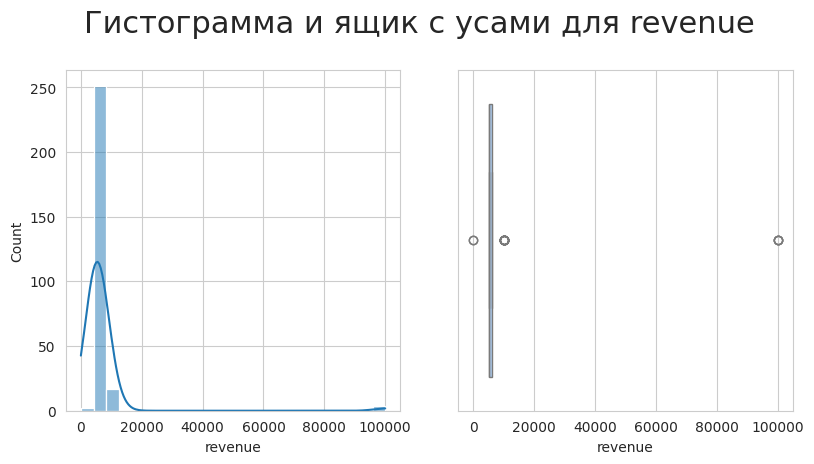

In [131]:
quantitative_analysis(df[df["revenue"].notna()], "revenue")

In [132]:
low, up = get_quantile(df[df["revenue"].notna()]["revenue"])
df = df[((df["revenue"] >= low) & (df["revenue"] <= up)) | (df["revenue"].isna())]
df["revenue"].value_counts()

revenue
4999.0    185
5999.0     66
Name: count, dtype: int64

### 1.1.8: session_duration_sec

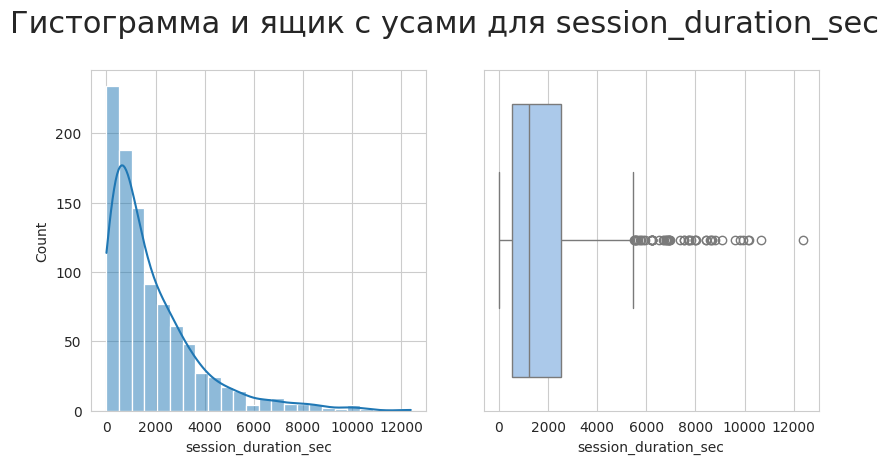

In [133]:
quantitative_analysis(df, "session_duration_sec")

In [134]:
low, up = get_quantile(df["session_duration_sec"])
# df = df[(df["session_duration_sec"] >= low) & (df["session_duration_sec"] <= up)]
condition = (df["session_duration_sec"] < low) | (df["session_duration_sec"] > up)
df[condition]["session_duration_sec"] = df["session_duration_sec"].median()

## 1.2: Новые метрики

### 1.2.1: revenue_with_discount
Итоговая сумма покупки с учетом применения промокода на скидку 10%

In [135]:
df['revenue_with_discount'] = df['revenue'] * (1 - df['promo_code'] * 0.1)
df.head()

,user_id,region,device,channel,session_start,session_end,session_duration_sec,session_date,month,day,hour_of_day,order_date,revenue,payment_type,promo_code,revenue_with_discount
1,601292388085,США,PC,без рекламы,2019-05-01 06:56:16,2019-05-01 07:09:18,782.0,2019-05-01,5,3,7,NaT,NaN,NaN,NaN,NaN
2,852898876338,США,Mac,социальные сети,2019-05-01 04:30:45,2019-05-01 04:34:56,251.0,2019-05-01,5,3,4,NaT,NaN,NaN,NaN,NaN
3,998513020664,США,iPhone,социальные сети,2019-05-01 18:53:42,2019-05-01 18:57:35,233.0,2019-05-01,5,3,18,NaT,NaN,NaN,NaN,NaN
4,240702200943,США,Mac,социальные сети,2019-05-02 14:04:32,2019-05-02 14:09:51,319.0,2019-05-02,5,4,14,NaT,NaN,NaN,NaN,NaN
5,271758921583,США,iPhone,социальные сети,2019-05-02 08:40:35,2019-05-02 08:41:15,40.0,2019-05-02,5,4,8,NaT,NaN,NaN,NaN,NaN


### 1.2.2: time_of_day

Временя суток визита

In [136]:
def part_of_day(hour):
    if 6 <= hour < 10:
        return 'утро'
    elif 10 <= hour < 17:
        return 'день'
    elif 17 <= hour < 22:
        return 'вечер'
    return 'ночь'


df['time_of_day'] = df['hour_of_day'].apply(part_of_day)

### 1.2.3: payer

столбец с информацией о том, является ли пользователь платящим или нет

In [137]:
df['payer'] = df['revenue'].apply(lambda x: 1 if x > 0 else 0)

## 1.3: Дубликаты

In [138]:
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

## 1.4: Проверка дат на соотвствие

In [139]:
df = df[(df['order_date'] >= df['session_start']) & (df['order_date'] <= df['session_end']) | (df["payer"] == 0)]
df.reset_index(drop=True, inplace=True)

## 1.5 Выводы по первому шагу

- Столбы приведены к формату PEP8
- Выявлены и убраны опечатки в категориальных данных
- Убраны пропуски, где необходимо
- Убраны строки с некорректными данными
- Убраны супервыбросы
- Убраны дубликаты
- Перевод данных в соответствующий формат
- Новые метрики

In [140]:
df.to_csv("preprocessed_data.csv")
print(f"Size - {df.shape[0]} rows and {df.shape[1]} columns.")
df.head()

Size - 971 rows and 18 columns.


,user_id,region,device,channel,session_start,session_end,session_duration_sec,session_date,month,day,hour_of_day,order_date,revenue,payment_type,promo_code,revenue_with_discount,time_of_day,payer
0,601292388085,США,PC,без рекламы,2019-05-01 06:56:16,2019-05-01 07:09:18,782.0,2019-05-01,5,3,7,NaT,NaN,NaN,NaN,NaN,утро,0
1,852898876338,США,Mac,социальные сети,2019-05-01 04:30:45,2019-05-01 04:34:56,251.0,2019-05-01,5,3,4,NaT,NaN,NaN,NaN,NaN,ночь,0
2,998513020664,США,iPhone,социальные сети,2019-05-01 18:53:42,2019-05-01 18:57:35,233.0,2019-05-01,5,3,18,NaT,NaN,NaN,NaN,NaN,вечер,0
3,240702200943,США,Mac,социальные сети,2019-05-02 14:04:32,2019-05-02 14:09:51,319.0,2019-05-02,5,4,14,NaT,NaN,NaN,NaN,NaN,день,0
4,271758921583,США,iPhone,социальные сети,2019-05-02 08:40:35,2019-05-02 08:41:15,40.0,2019-05-02,5,4,8,NaT,NaN,NaN,NaN,NaN,утро,0


# **Шаг 2: Аналитический и графический анализ данных**

### 2.1: Доля продаж по регионам

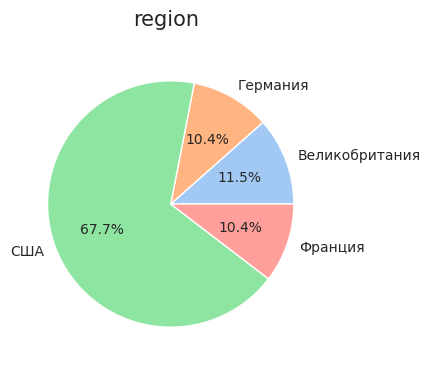

In [141]:
print_pie(df, "region")

***Вывод:*** США является главным регионом продаж с долей в 67.7%. Другие страны Европы: Великобритания, Германия и Франция имеют примерно равные доли рынка 11.5%, 10.4% и 10.4% соответственно.

### 2.2: Доля продаж по источникам

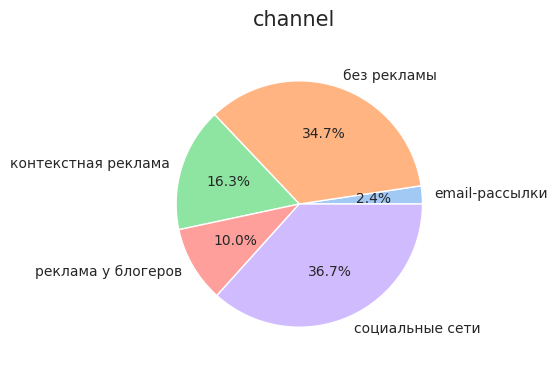

In [142]:
print_pie(df, "channel")

***Вывод:*** Основной вклад в продажи вносят социальные сети с долей в 36.7%. За ними следует контекстная реклама с долей 16.3%. Реклама у блогеров занимает третье место с долей в 10%, а email-рассылки имеют самую низкую долю продаж в 2.4%. При этом на рекламу не приходится целых 34.7% от общего объема продаж, что подчеркивает важность использования других, более эффективных каналов привлечения клиентов.(Например, телевидение/радио/пресса/выставки и конференции/участие в партнерских программах/акции и специальные предложения/SEO-оптимизация сайта)

### 2.3: Доля продаж по устройствам

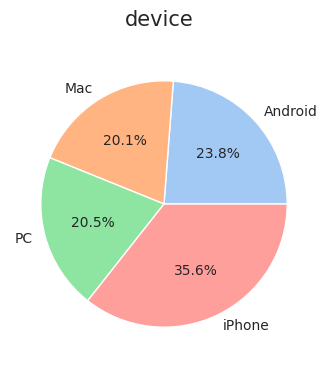

In [143]:
print_pie(df, "device")

***Вывод:*** Наибольшая доля продаж приходится на iPhone - 35.6%, за ним следует Android - 23.8%. Устройства Mac и PC имеют примерно равные доли рынка в 20.1% и 20.5%.

### 2.4: Количество пользователей с разбивкой на платящих/не платящих по регионам

payer             0    1
region                  
Великобритания   83   29
Германия         78   23
США             483  174
Франция          78   23


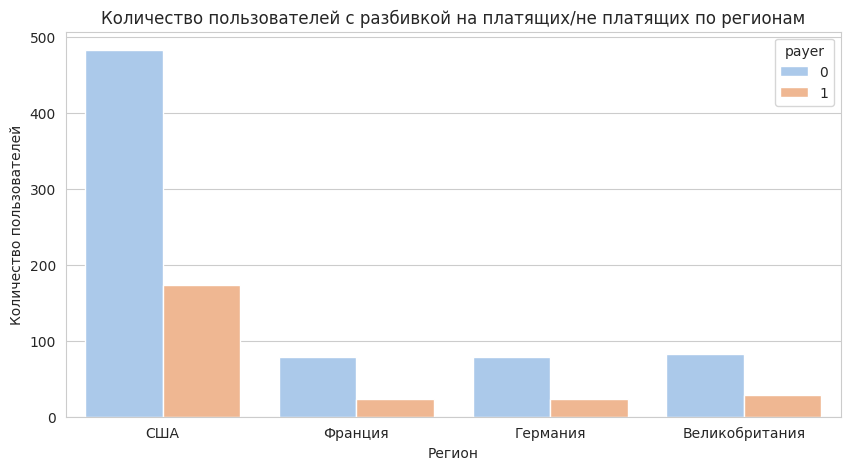

In [144]:
region_payers = df.groupby(['region', 'payer']).size().unstack()
print(region_payers)
plt.figure(figsize=(10, 5))
sns.countplot(x=df['region'], hue=df['payer'], palette=PALETTE)
plt.title('Количество пользователей с разбивкой на платящих/не платящих по регионам')
plt.xlabel('Регион')
plt.xticks(rotation=0)
plt.ylabel('Количество пользователей')
plt.show()

***Вывод:*** Наибольшее количество плательщиков проживает в Соединенных Штатах (174), за ними следуют Великобритания (29), Германия и Франция с равным количеством человек(23).

Наибольшее количество неплательщиков также проживает в Соединенных Штатах (483), за ними идет Великобритания (83), Германия и Франция с равным количеством человек (78).

Общее количество пользователей больше всего в США, что может объяснить набольшое количество и плательщиков, и неплательщиков в этой стране.


### 2.5: Количество пользователей с разбивкой на платящих/не платящих по устройствам

payer      0   1
device          
Android  164  67
Mac      142  53
PC       155  44
iPhone   261  85


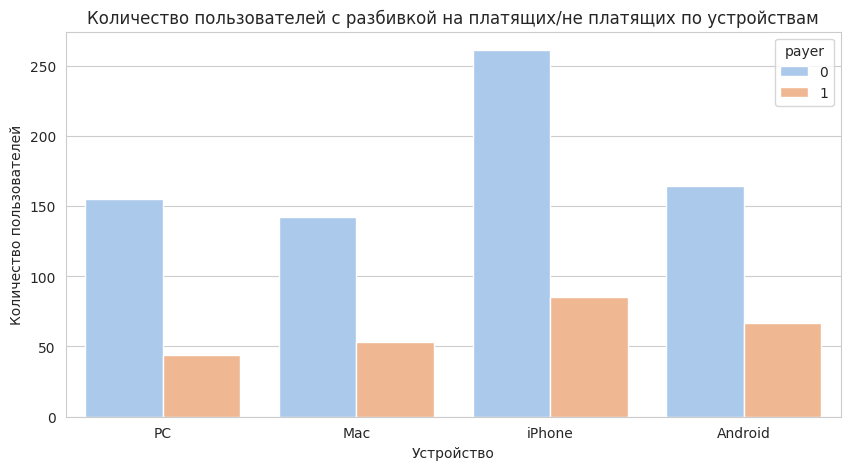

In [145]:
device_payers = df.groupby(['device', 'payer']).size().unstack()
print(device_payers)
plt.figure(figsize=(10, 5))
sns.countplot(x=df['device'], hue=df['payer'], palette=PALETTE)
plt.title('Количество пользователей с разбивкой на платящих/не платящих по устройствам')
plt.xlabel('Устройство')
plt.ylabel('Количество пользователей')
plt.xticks(rotation=0)
plt.show()


***Вывод:*** Наибольшее количество плательщиков обладатели Iphone (85), за ними следуют пользователи Android (67), Mac и PC используют (53) и (44) плательщика.

Наибольшее количество неплательщиков обладатели Iphone (261), за ними следуют пользователи Android (164), Mac и PC используют (142) и (155) неплательщиков.

Общее количество пользователей iPhone и Android также больше, чем Mac и PC, что может объяснить более высокое количество плательщиков среди этих устройств.


### 2.6: Количество пользователей с разбивкой на платящих/не платящих по источникам

payer                  0   1
channel                     
email-рассылки        17   6
без рекламы          259  78
контекстная реклама  117  41
реклама у блогеров    71  26
социальные сети      258  98


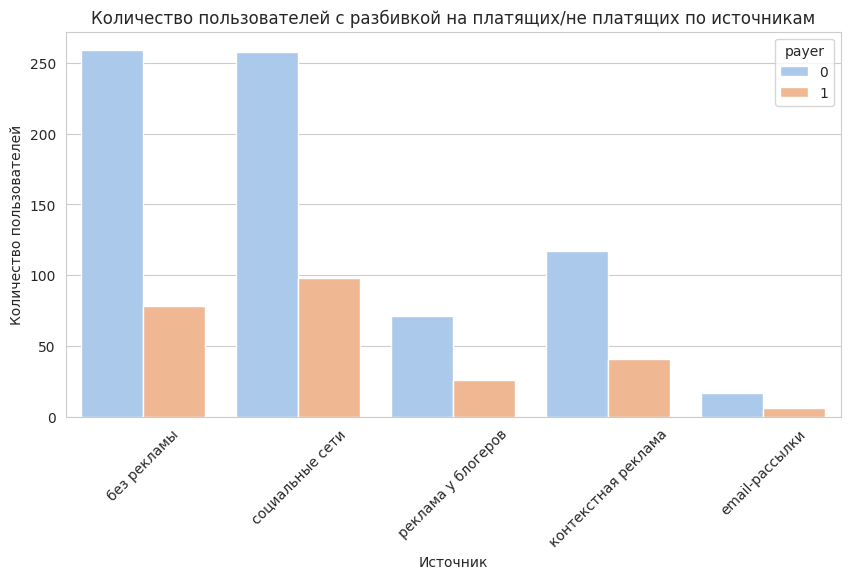

In [146]:
channel_payers = df.groupby(['channel', 'payer']).size().unstack()
print(channel_payers)
plt.figure(figsize=(10, 5))
sns.countplot(x=df['channel'], hue=df['payer'], palette=PALETTE)
plt.title('Количество пользователей с разбивкой на платящих/не платящих по источникам')
plt.xlabel('Источник')
plt.ylabel('Количество пользователей')
plt.xticks(rotation=45)
plt.show()

***Вывод:***   Наибольшее количество плательщиков предпочитают получать информацию из социальных сетей (98) и контекстной рекламы (41). Реклама у блогеров и email-рассылки привлекли (26) и (6) человек. Почти 32% плательщиков в размере (78) человек пришли без рекламы.

Наибольшее количество неплательщиков предпочитают получать информацию из социальных сетей (258) и контекстной рекламы (117). Реклама у блогеров и email-рассылки привлекли (71) и (17) человек. Почти 36% неплательщиков в размере (259) человек пришли без рекламы.

### 2.7: График сезонности в продажах по месяцам  

month
5     105580.2
6     235056.1
7     203260.9
8     324039.1
9     182864.6
10    223757.0
Name: revenue_with_discount, dtype: float64


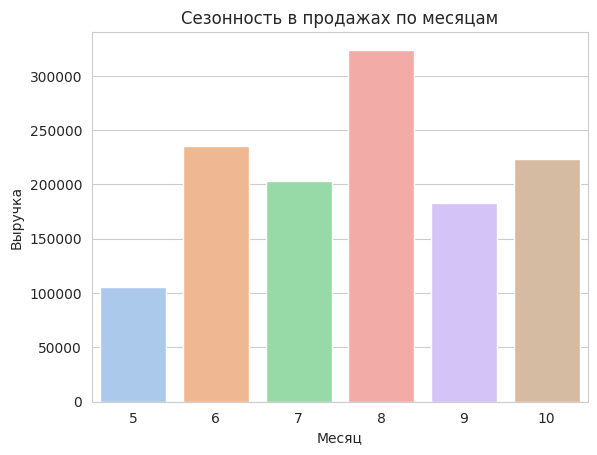

In [147]:
month_rev = df.groupby('month')['revenue_with_discount'].sum()
print(month_rev)

print_bar_plot(month_rev, 'Сезонность в продажах по месяцам', 'Месяц', 'Выручка')

***Вывод:*** Самым прибыльным месяцем был август, выручка составила (324039.1), что в три раза превышает самую маленькую выручку - в мае (105580.2). Июнь, июль и октябрь имели примерно равную вырочку в (235056.1), (203260.9) и (223757.0). В сентябре выручка была средней - (182864.6). В летние месяцы (июнь, июль, август) была заметна стабильная и большая выручка.

### 2.8: График сезонности в продажах по дням недели

day
1    189763.6
2    191163.9
3    166669.0
4    160368.9
5    214659.8
6    197062.3
7    154870.4
Name: revenue_with_discount, dtype: float64


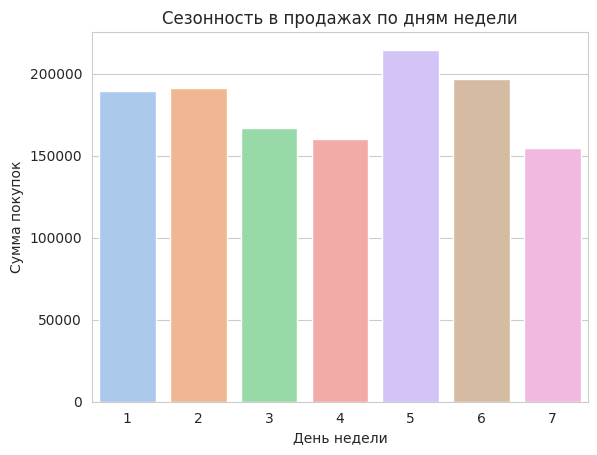

In [148]:
day_rev = df.groupby('day')['revenue_with_discount'].sum()
print(day_rev)

print_bar_plot(day_rev, 'Сезонность в продажах по дням недели', 'День недели', 'Сумма покупок')

***Вывод:*** Самый прибыльный день недели - пятница, прибыль за пятницы составила (214659.8), за ней следует суббота (197062.3). Самая маленькая прибыль по воскресеньям (154870.4). Есть тенденция снижения прибыли с понедельника по четверг, затем большая выручка в пятницу и снова снижение дохода до воскресенья.


### 2.9: График сезонности в продажах по времени суток

time_of_day
утро     252651.4
вечер    263550.0
день     325338.5
ночь     433018.0
Name: revenue_with_discount, dtype: float64


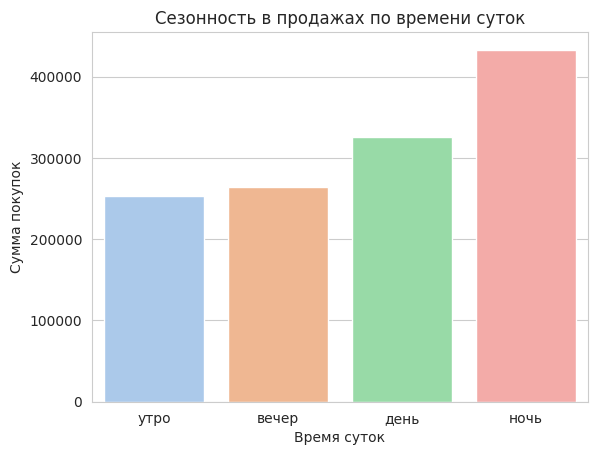

In [149]:
time_rev = df.groupby('time_of_day')['revenue_with_discount'].sum()
time_rev = time_rev.sort_values()
print(time_rev)

print_bar_plot(time_rev, 'Сезонность в продажах по времени суток', 'Время суток', 'Сумма покупок')

***Вывод:*** Наиболее прибыльное время суток - ночь(с 22 до 6 утра) 433018.0.  Наименьшая прибыль, которая в 1.7 раза меньше ночной,  зафиксирована утром (с 6 до 10 утра) (252651.4). Продажи днем и вечером составили (325338.5) и (263550.0).

### 2.10: Диаграмма количества покупок по типу оплаты

payment_type
Дебетовая карта        32
Кредитная карта        33
Наличные               53
Электронный кошелёк    60
Мобильный платеж       71
Name: count, dtype: int64


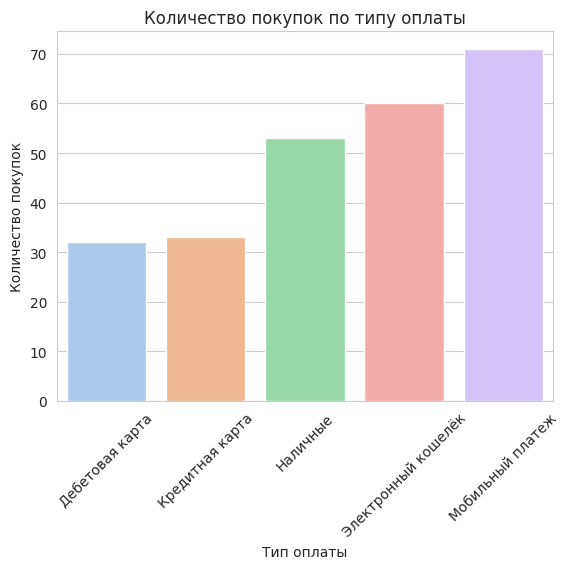

In [150]:
pay_count = df['payment_type'].value_counts()
pay_count = pay_count.sort_values()
print(pay_count)

print_bar_plot(pay_count, 'Количество покупок по типу оплаты', 'Тип оплаты', 'Количество покупок', 45)

***Вывод:*** Самым популярным способом оплаты являются мобильные платежи (71). Затем идут электронные кошельки (60) и наличные (53). Кредитными и дебетовыми картами пользуются реже всего: (33) и (32). Возможно, это связано с ростом популярности мобильных приложений для оплаты и удобством использования электронных кошельков. Однако, оплата наличными также остается популярным способом оплаты.

# **Шаг 3: Проведение расчетов**

### 3.1: Средний чек

In [151]:
av_check= df['revenue_with_discount'].mean()
av_check2 = df['revenue'].mean()
print(av_check, av_check2)

5118.7064257028105 5264.060240963855


***Вывод:*** Cредний чек покупателя с учетом скидки составляет 5119, без скидки 5264. Разница 145

### 3.2: Среднее количество покупок на одного пользователя

In [152]:
buys_per_user = df.groupby('user_id')['order_date'].count().mean()
print(buys_per_user)

0.2564366632337796


***Вывод:*** Среднее количество покупок на одного пользователя составляет примерно 0.26, то есть пользователи совершают покупки достаточно редко. Нам нужно понять, как можно увеличить активность пользователей и количество покупок.

### 3.3: Средняя продолжительность сессии по рекламным каналам

channel
социальные сети        1673.991573
без рекламы            1874.919881
реклама у блогеров     1887.350515
email-рассылки         1919.260870
контекстная реклама    1974.139241
Name: session_duration_sec, dtype: float64


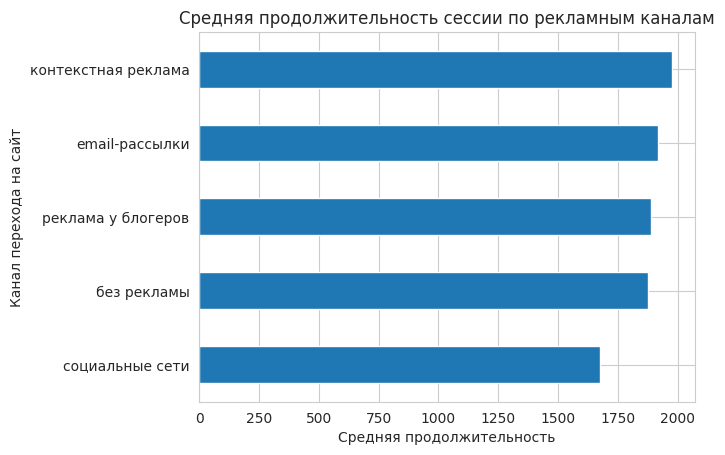

In [153]:
session_by_chan = df.groupby('channel')['session_duration_sec'].mean()
session_by_chan = session_by_chan.sort_values()
print(session_by_chan)
session_by_chan.plot(kind='barh')
plt.xlabel('Средняя продолжительность')
plt.ylabel('Канал перехода на сайт')
plt.title('Средняя продолжительность сессии по рекламным каналам')
plt.show()

***Вывод:*** Наибольшее время на сайте проводят пользователи, пришедшие по контекстной рекламе (1974.14). За ней следует email-рассылки (1919.26). Пользователи пришедшие по рекламе блогеров и без рекламы имеют примерно равное время на сайте (1887.35) и (1874.92). Наименьшее время на сайте проводят пользователи пришедшие из социальных сетей (1673.99).

Контекстная реклама и email-рассылки являются наиболее эффективным каналами, а значит, при распределении бюджета на рекламу им стоит уделить большее внимание.

### 3.4: Рассчитать среднюю продолжительность сессии по типу устройства

device
iPhone     1725.976879
Mac        1798.343590
Android    1875.727273
PC         1938.497487
Name: session_duration_sec, dtype: float64


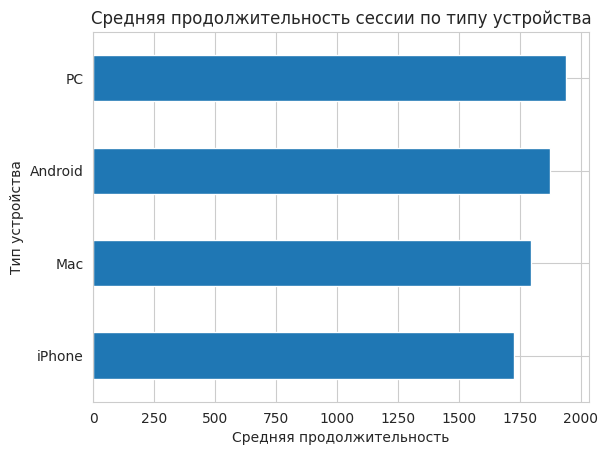

In [154]:
session_by_dev = df.groupby('device')['session_duration_sec'].mean()
session_by_dev = session_by_dev.sort_values()
print(session_by_dev)
session_by_dev.plot(kind='barh')
plt.xlabel('Средняя продолжительность')
plt.ylabel('Тип устройства')
plt.title('Средняя продолжительность сессии по типу устройства')
plt.show()

***Вывод:*** Пользователи PC проводят на сайте больше всех времени (1938.49). Затем идут пользователи Android (1875.73).  Наименьшее количество времени на сайте проводят обладатели iPhone (1725.97).



### 3.5: Топ-3 рекламных канала по среднему чеку

channel
email-рассылки        5332.366667
реклама у блогеров    5241.319231
социальные сети       5130.656122
Name: revenue_with_discount, dtype: float64


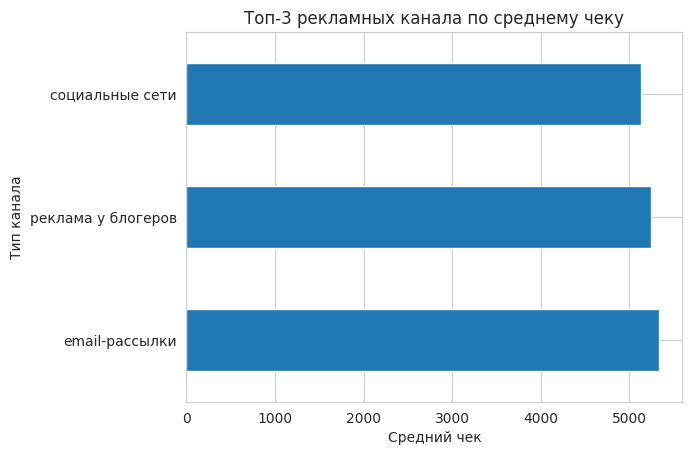

In [155]:
top3_ch = df.groupby('channel')['revenue_with_discount'].mean().sort_values(ascending=False).head(3)
print(top3_ch)
top3_ch.plot(kind='barh')
plt.xlabel('Средний чек')
plt.ylabel('Тип канала')
plt.title('Топ-3 рекламных канала по среднему чеку')
plt.show()

***Вывод:*** Топ-3 рекламных канала по среднему чеку


1.   email-рассылки        5332.37
2.   реклама у блогеров    5241.32
3.   социальные сети       5130.656

Email-рассылки являются самым прибыльным рекламным каналом по среднему чеку(5332.37). Возможно потому, что чаще всего email-рассылки приходят именно целевой аудитории, уже знающей о продукте. Реклама у блогеров занимает второе место (5241.32). А значит, были выбраны подходящие блогеры с заинтересованными в нашем продукте подписчиками.  Социальные сети занимают третье место по среднему чеку (5130.656).

Есть ли смысл графика?




### 3.6: Топ-3 региона по среднему чеку

region
Франция           5255.547826
Великобритания    5233.503448
Германия          5142.508696
Name: revenue_with_discount, dtype: float64


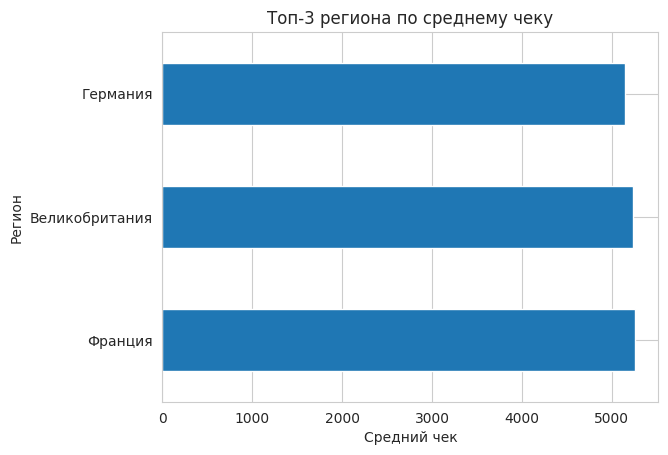

In [156]:
top3_reg = df.groupby('region')['revenue_with_discount'].mean().sort_values(ascending=False).head(3)
print(top3_reg)
top3_reg.plot(kind='barh')
plt.xlabel('Средний чек')
plt.ylabel('Регион')
plt.title('Топ-3 региона по среднему чеку')
plt.show()

***Вывод:*** Топ-3 региона по среднему чеку
*   France     5255.55
*   UK-------5233.50
*   Germany    5142.51

Франция занимает первое место регионов по среднему чеку (5255.55).
Второе место занимает Великобритания, с средним чеком в (5233.50).
На третьем месте находится Германия, с средним чеком в (5142.51).
(Возможно в этих странах разработка дронов вообще не ведется, в отличие от сша например, поэтому скупают)-додумать. +
график нужен?

# **Шаг 4: Проверка гипотез**

### 4.1: Влияет ли тип устройства на количество покупок в день по каждому региону?

Из приведённого ниже графика мы можем сделать следующие выводы:

1) Во всех регионах значимую часть покупателей занимают обладатели Android устройств.
2) В самом прибыльном регионе (США) чаще всего совершают покупки обладатели IOS устройств. Это связано с тем, что в Америке IOS устройства пользуются огромным спросом.

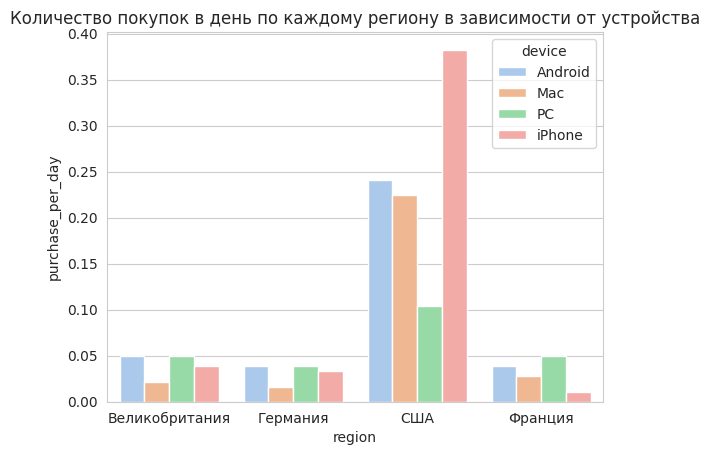

In [157]:
orders = df[df['order_date'].notnull()]
days_count = (df["session_date"].max() - df["session_date"].min()).days # количество дней в диапазоне дат

grouped_data = orders.groupby(['region', 'device']).size().apply(lambda x: x / days_count).reset_index(name='purchase_per_day')

sns.barplot(data=grouped_data, x='region', y='purchase_per_day', hue='device', palette=PALETTE)
plt.title("Количество покупок в день по каждому региону в зависимости от устройства")
plt.show()

### 4.2: Влияет ли тип рекламного канала на количество покупок в день по каждому региону?

Из приведённого ниже графика мы можем сделать следующие выводы:

1) В Америке чаще всего совершают покупки те, кто узнал о магазине через социальные сети. Разница между каналами рекламы очень существенная. Реклама у блогеров и контекстная реклама не приносят столько же, поэтому, возможно, следует отказаться от этих способов. Также многие покупатели узнают о магазине не из рекламы.
2) В остальных регионах о магазине не узнают из соц сетей. На примере Америки, это был самый эффективный способ рекламы магазина, поэтому стоит попробовать рекламировать магазин через соцальные сети и в других регионах.
3) В Германии, Великобритании и Франции самый эффективный канал рекламы - контекстная реклама.
4) Email-рассылки - самый неэффективный канал рекламы. Возможно, следует отказаться от этого способа.

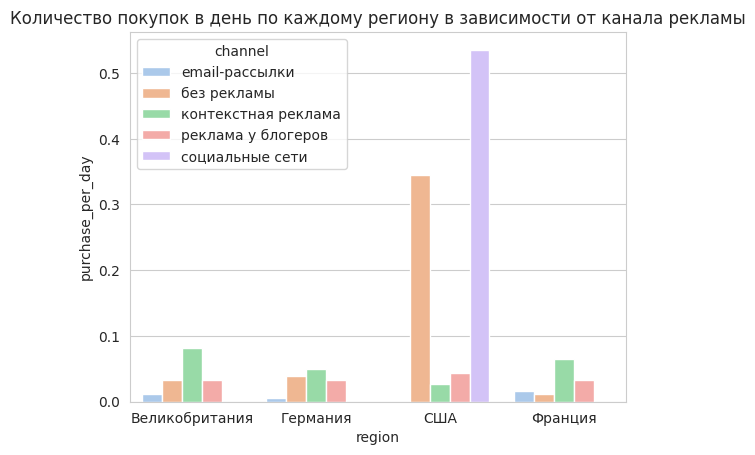

In [158]:
grouped_data = orders.groupby(['region', 'channel']).size().apply(
    lambda x: x / days_count
).reset_index(name='purchase_per_day')

sns.barplot(data=grouped_data, x='region', y='purchase_per_day', hue='channel', palette=PALETTE)
plt.title("Количество покупок в день по каждому региону в зависимости от канала рекламы")
plt.show()

### 4.3: Cредний чек отличается в зависимости от региона?

Нет, средний чек примерно одинаковый.

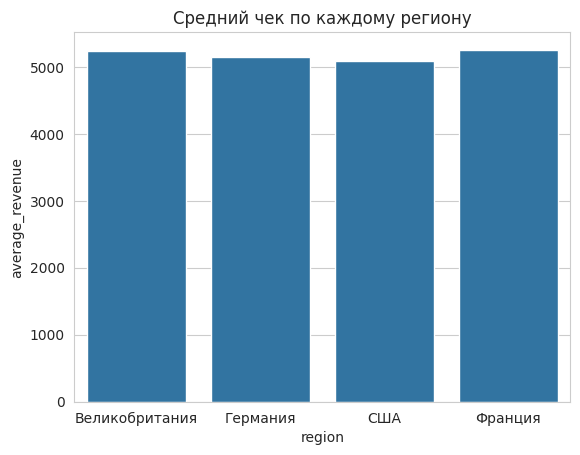

In [159]:
grouped_data = orders.groupby('region')["revenue_with_discount"].mean().reset_index(name='average_revenue')

sns.barplot(data=grouped_data, x='region', y='average_revenue')
plt.title("Средний чек по каждому региону")
plt.show()

### 4.4: Cредний чек отличается в зависимости от рекламного канала?

### 4.5: Cредний чек отличается в зависимости от времени суток?

### 4.6: Есть ли взаимосвязь между продолжительностью сессии с суммой покупок?

Из графика и коэффициента корреляции можно сделать вывод, что продолжительность сессии никак не влияет на сумму покупок.

Корреляция между выручкой с учетом скидки и длительностью сеанса: 0.012682191105704836


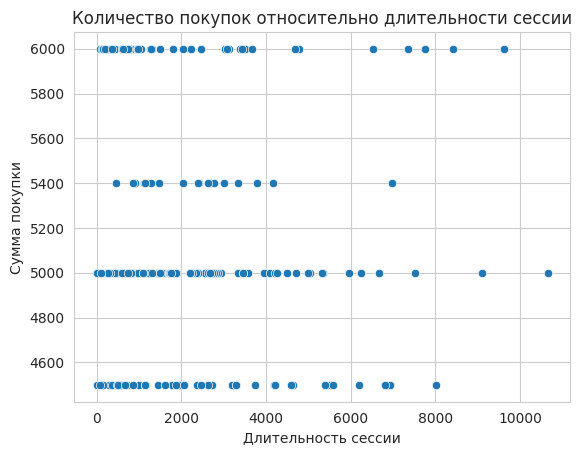

In [160]:
k = df[["revenue_with_discount", "session_duration_sec"]].corr().loc["revenue_with_discount", "session_duration_sec"]
print(f"Корреляция между выручкой с учетом скидки и длительностью сеанса: {k}")

sns.scatterplot(data=df, y="revenue_with_discount", x='session_duration_sec', palette=PALETTE)
plt.xlabel('Длительность сессии')
plt.ylabel('Сумма покупки')
plt.title('Количество покупок относительно длительности сессии')
plt.show()

### 4.7: Придумать

### 4.8: Придумать

# Шаг 5: Регрессионное моделирование

## 5.1: Все регионы

### 5.1.0: Подготовка

Чтобы понять, насколько развивается бизнес, требуется:

- Добавить фактор, выражающий количество покупок ежемесячно.
- Посчитать, сколько раз встречаются уникальные значения номинальных шкал ежемесячно.
- Убрать неподходящие для обучения шкалы (id, номинальные и даты)

In [161]:
month_purchases = df[df["payer"] == 1].groupby("month")["revenue_with_discount"].count()

timestamp_columns = df.select_dtypes(include=['datetime64']).columns
nominal_columns = df.select_dtypes(include=[object]).columns

regr_df = df.drop(columns=[*timestamp_columns, "user_id", "revenue"])
regr_df["month_revenue"] = regr_df["month"].map(month_purchases)

channels = regr_df.groupby("month")["channel"].value_counts().unstack(fill_value=0)
for channel in df["channel"].unique():
    regr_df[channel.replace(" ", "_")] = regr_df["month"].map(channels[channel])

devices = regr_df.groupby("month")["device"].value_counts().unstack(fill_value=0)
for device in df["device"].unique():
    regr_df[device.replace(" ", "_").lower()] = regr_df["month"].map(devices[device])
'''
regions = regr_df.groupby("month")["region"].value_counts().unstack(fill_value=0)
for region in df["region"].unique():
    regr_df[region.replace(" ", "_").lower()] = regr_df["month"].map(regions[region])
'''
regr_df.drop(columns=nominal_columns, inplace=True)

### 5.1.1: Выбор факторов

Чтобы понять, какие факторы влияют на целевой фактор (количество покупок ежемесячно), необходимо узнать коэф-ы корреляций. Возьмём самый большой по модулю.

In [162]:
correlations = regr_df.corr()["month_revenue"].sort_values(key=abs, ascending=False)
top_correlations = correlations[abs(correlations) >= 0.5][1:]
top_correlation = top_correlations.index[0]
top_correlations

android                0.746411
контекстная_реклама    0.630294
реклама_у_блогеров     0.601578
iphone                 0.575136
Name: month_revenue, dtype: float64

### 5.1.2: Модель

Разделим выборку на тренировочную и тестовую. Подставим в модель линейной регрессии тренировочную.

In [163]:
X_train, X_test, y_train, y_test = train_test_split(
    regr_df[[top_correlation]], regr_df["month_revenue"],
    test_size=TEST_SIZE, random_state=RANDOM_STATE
)

model = LinearRegression()
model.fit(X_train, y_train)
print("Модель линейной регрессии")

Модель линейной регрессии


### 5.1.3: Предсказание

Из полученных метрик, можно сделать вывод, что наша модель относительно точная.

In [164]:
predictions = model.predict(X_test)

mae = metrics.mean_absolute_error(y_test, predictions)
mse = metrics.mean_squared_error(y_test, predictions)
r2 = metrics.r2_score(y_test, predictions)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R^2: {r2}")

MAE: 6.990383605117143
MSE: 69.41064546055078
R^2: 0.48611636464523766


### 5.1.4: Корреляция предсказания и реальных данных

Из полученных данных, можно убедиться, что наша модель относительно точная.

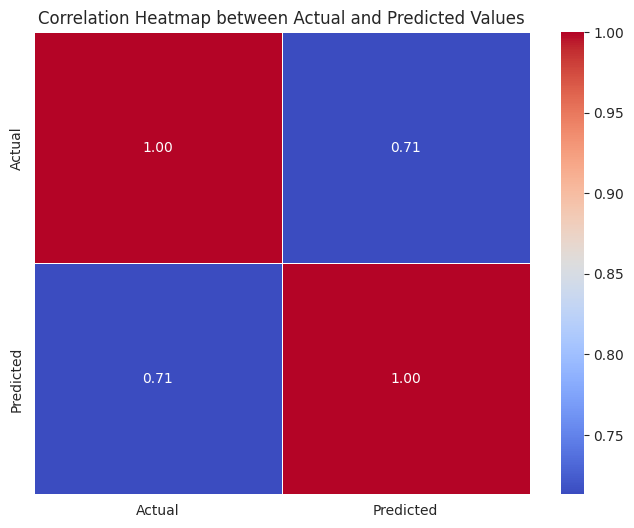

In [165]:
prediction_vs_actual = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
prediction_vs_actual_corr = prediction_vs_actual.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(prediction_vs_actual_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap between Actual and Predicted Values')
plt.show()

### 5.1.5: Регрессия графически

Мы, в целом, видим, что продажи растут для пользователей Android.

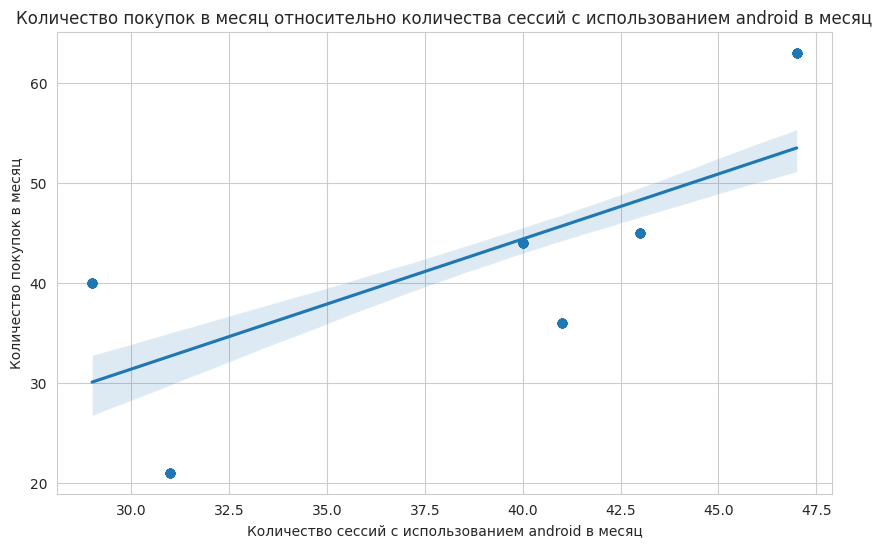

In [166]:
regression_visual(X_test, y_test, predictions, top_correlation)

### 5.1.6: Вывод

Продажи растут. Возможно, стоит рекламировать разные продукты для пользователей разных устройств. Стоит развивать рекламу для пользователей Andoid, потому что они занимают значимую часть в каждом регионе.

## 5.2: Регион США

Я считаю, что регион США нужно рассмотреть отдельно, тк в этом регионе самые большие продажи.

### 5.2.0: Подготовка

Чтобы понять, насколько развивается бизнес, требуется:

- Добавить фактор, выражающий количество покупок ежемесячно.
- Посчитать, сколько раз встречаются уникальные значения номинальных шкал ежемесячно.
- Убрать неподходящие для обучения шкалы (id, номинальные и даты)

In [167]:
month_purchases = df[(df["payer"] == 1) & (df["region"] == "США")].groupby("month")["revenue_with_discount"].count()

regr_df = df[df["region"] == "США"].drop(columns=[*timestamp_columns, "user_id", "revenue"])
regr_df["month_revenue"] = regr_df["month"].map(month_purchases)

channels = regr_df.groupby("month")["channel"].value_counts().unstack(fill_value=0)
for channel in df[df["region"] == "США"]["channel"].unique():
    regr_df[channel.replace(" ", "_")] = regr_df["month"].map(channels[channel])

devices = regr_df.groupby("month")["device"].value_counts().unstack(fill_value=0)
for device in df[df["region"] == "США"]["device"].unique():
    regr_df[device.replace(" ", "_").lower()] = regr_df["month"].map(devices[device])

regr_df.drop(columns=nominal_columns, inplace=True)

### 5.2.1: Выбор факторов

Чтобы понять, какие факторы влияют на целевой фактор (количество покупок ежемесячно), необходимо узнать коэф-ы корреляций. Возьмём самый большой по модулю. Проверим, как влияет реклама через социальные сети на кол-во покупок в месяц, тем самым дополним выводы по шагу 4.2.

In [168]:
correlations = regr_df.corr()["month_revenue"].sort_values(key=abs, ascending=False)
top_correlations = correlations[abs(correlations) >= 0.45][1:]
top_correlation = top_correlations.index[0]
top_correlations

социальные_сети        0.580676
без_рекламы           -0.546152
контекстная_реклама    0.545531
реклама_у_блогеров     0.523189
mac                    0.519491
month                  0.510395
Name: month_revenue, dtype: float64

### 5.2.2: Модель

Разделим выборку на тренировочную и тестовую. Подставим в модель линейной регрессии тренировочную.

In [169]:
X_train, X_test, y_train, y_test = train_test_split(
    regr_df[[top_correlation]], regr_df["month_revenue"],
    test_size=TEST_SIZE, random_state=RANDOM_STATE
)

model = LinearRegression()
model.fit(X_train, y_train)
print("Модель линейной регрессии")

Модель линейной регрессии


### 5.2.3: Предсказание

Из полученных метрик, можно сделать вывод, что наша модель относительно точная. Она могла быть точнее, если бы было больше данных.

In [170]:
predictions = model.predict(X_test)

mae = metrics.mean_absolute_error(y_test, predictions)
mse = metrics.mean_squared_error(y_test, predictions)
r2 = metrics.r2_score(y_test, predictions)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R^2: {r2}")

MAE: 5.80221532019694
MSE: 43.52871507677847
R^2: 0.4081624191681107


### 5.2.4: Корреляция предсказания и реальных данных

Из полученных данных, можно убедиться, что наша модель относительно точно предсказала значения целевого фактора.

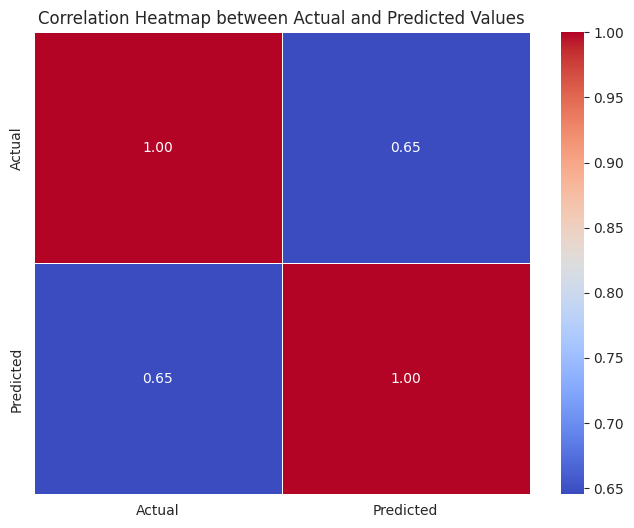

In [171]:
prediction_vs_actual = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
prediction_vs_actual_corr = prediction_vs_actual.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(prediction_vs_actual_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap between Actual and Predicted Values')
plt.show()

### 5.2.5: Регрессия графически

Мы, в целом, видим, что продажи растут для пользователей, узнавших про магазин через социальные сети.

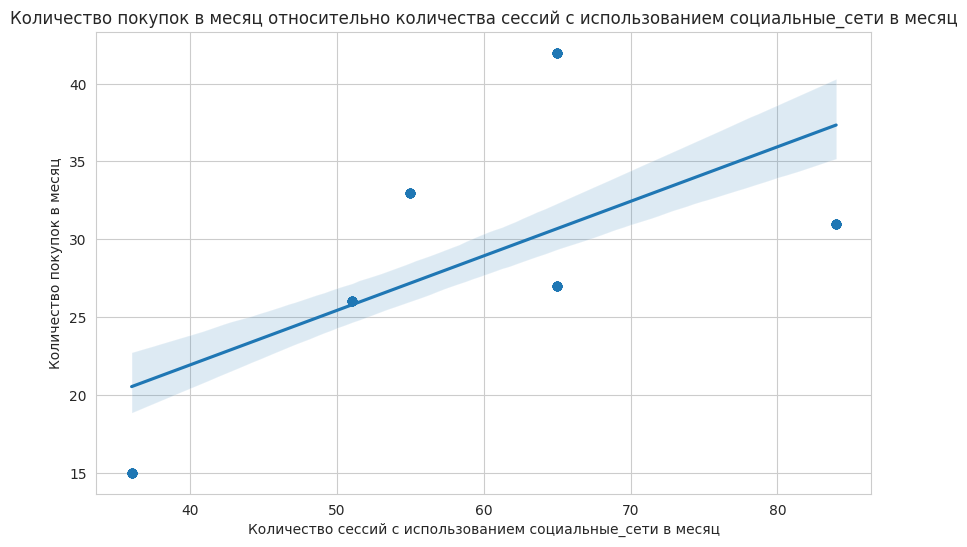

In [172]:
regression_visual(X_test, y_test, predictions, top_correlation)

### 5.2.6: Вывод

Стоит развивать рекламу в социальных сетях (и не только в Америке), потому что продажи растут.